In [1]:
import sys
import datetime

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

import pandas as pd

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('../../..')
    import covid19_inference as cov19

df = cov19.get_rki()

In [48]:
df['date_ref'] = df['Refdatum'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e3))
df['date_diff_days'] = (df['date'] - df['date_ref']).apply(lambda x:x.days)

series_melde = df.groupby('date')['AnzahlFall'].sum().cumsum()
series_ref = df.groupby('date_ref')['AnzahlFall'].sum().cumsum()
series_ref_certain = df[df['date_diff_days'] != 0].groupby('date_ref')['AnzahlFall'].sum().cumsum()
df_jhu = cov19.get_jhu_cdr('Germany', None)

date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = datetime.datetime(2020,4,9)

# Meldedatum - Refdatum

## Meldedatum: Datum, wann der Fall dem Gesundheitsamt bekannt geworden ist

## Referenzdatum: Erkrankungsdatum bzw. wenn das nicht bekannt ist, das Meldedatum

(array([1.8000e+01, 2.6000e+01, 3.7000e+01, 6.8000e+01, 1.5400e+02,
        2.4022e+04, 3.3340e+03, 5.9420e+03, 6.9890e+03, 7.0950e+03,
        6.8330e+03, 6.1810e+03, 5.7040e+03, 4.6660e+03, 3.9870e+03,
        3.5090e+03, 2.8000e+03, 2.1850e+03, 1.6800e+03, 1.4430e+03,
        1.0680e+03, 8.0300e+02, 5.8500e+02, 4.7500e+02, 6.2800e+02]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
         8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.]),
 <a list of 25 Patch objects>)

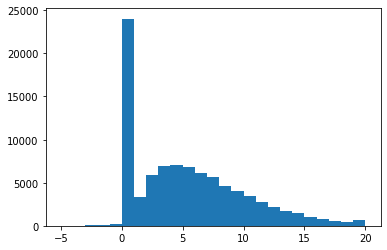

In [45]:
df['date_diff'] = df['date'] - df['date_ref']
plt.hist(df['date_diff_days'].to_list(), bins=25, range=[-5,20])
plt.title('Meldedatum - Refdatum')
plt.xlabel('days')

# Meldedatum, Refdatum, JHU

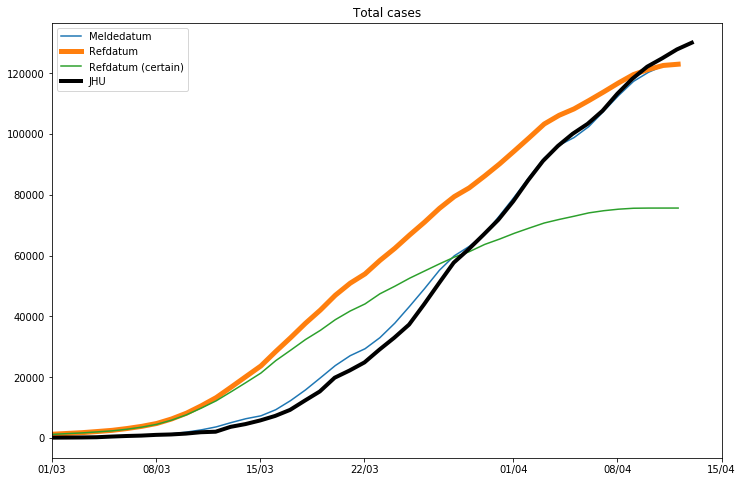

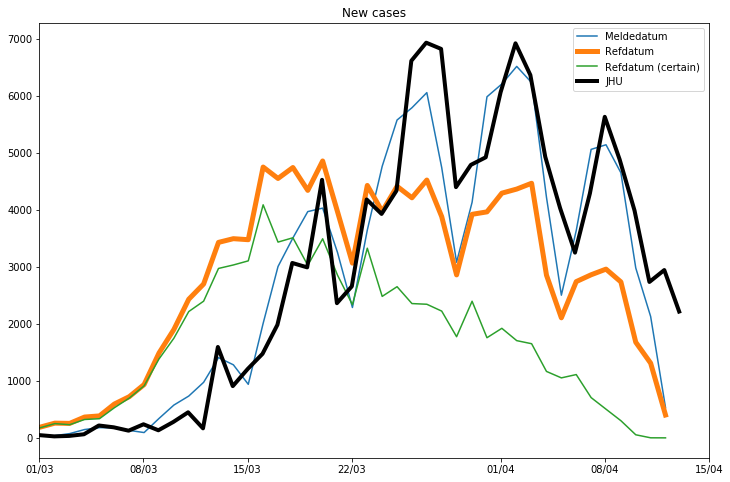

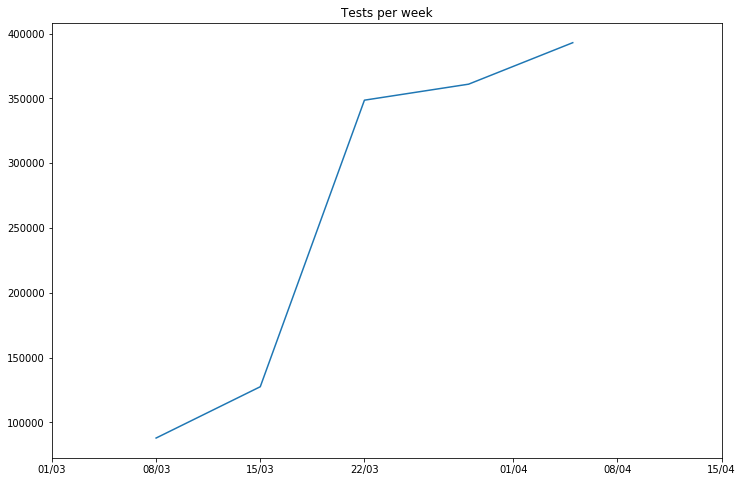

In [61]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,8))
plt.plot(series_melde, label='Meldedatum')
plt.plot(series_ref,label='Refdatum', lw=5)
plt.plot(series_ref_certain,label='Refdatum (certain)')
plt.plot(df_jhu['confirmed'], label='JHU', lw=4, color='k')
plt.title('Total cases')
plt.xlim([datetime.datetime(2020,3,1), datetime.datetime(2020,4,15)])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.legend()
         
plt.figure(figsize=(12,8))
plt.plot(series_melde.diff(),label='Meldedatum')
plt.plot(series_ref.diff(),label='Refdatum', lw=5)
plt.plot(series_ref_certain.diff(),label='Refdatum (certain)')
plt.plot(df_jhu['confirmed'].diff(), label='JHU', lw=4, color='k')
plt.title('New cases')
plt.xlim([datetime.datetime(2020,3,1), datetime.datetime(2020,4,15)])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.legend()

tests_day = [datetime.datetime(2020,3,8),datetime.datetime(2020,3,15),datetime.datetime(2020,3,22),datetime.datetime(2020,3,29), datetime.datetime(2020,4,5)]
tests_count = [87863,127457,348619,360964,392984]
plt.figure(figsize=(12,8))
plt.plot(tests_day, tests_count)
plt.xlim([datetime.datetime(2020,3,1), datetime.datetime(2020,4,15)])
plt.title('Tests per week')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

# Refdatum - 3 points

In [62]:
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days

cases_obs =  np.array(series_ref[date_data_begin:date_data_end])

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5)]

model = cov19.SIR_with_change_points(np.diff(cases_obs),
                                        change_points,
                                        date_begin_sim,
                                        num_days_sim,
                                        diff_data_sim,
                                     N=83e6)

trace = pm.sample(model=model, init='advi', cores=6)
print(pm.loo(trace, model))

pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
pr_median_transient_len of change point 0 was set to default value 3
pr_median_transient_len of change point 1 was set to default value 3
pr_median_transient_len of change point 2 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3
pr_sigma_transient_len of change point 1 was set to default value 0.3
pr_sigma_transient_len of change point 2 was set to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 364.5:   7%|▋         | 14751/200000 [00:27<05:40, 543.77it/s] 
Convergence achieved at 14800
Interrupted at 14,799 [7%]: Average Loss = 474.56
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay, mu, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0, lambda_3, lambda_2, lambda_1, lambda_0, I_begin]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [04:16<00:00, 15.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


Computed from 2000 by 38 log-likelihood matrix

       Estimate       SE
IC_loo   574.72    12.31
p_loo      9.81        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       36   94.7%
 (0.5, 0.7]   (ok)          1    2.6%
   (0.7, 1]   (bad)         1    2.6%
   (1, Inf)   (very bad)    0    0.0%



/home/joaopn/Software/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


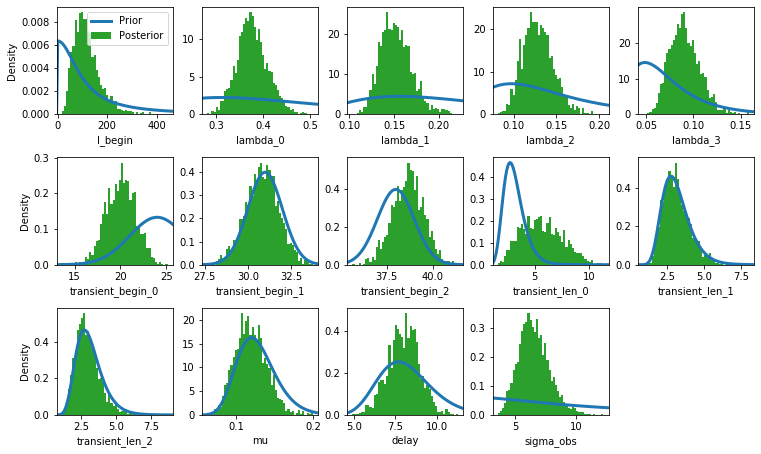

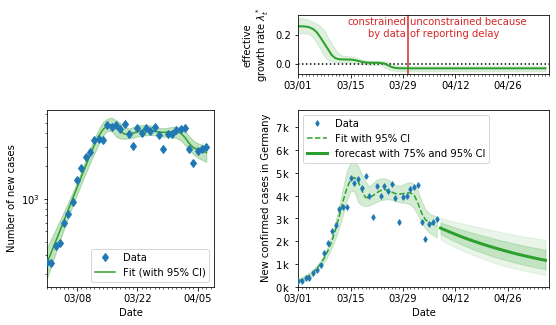

In [63]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig2, axes = cov19.plotting.plot_cases(trace, np.diff(cases_obs), date_begin_sim, diff_data_sim,
                                      colors=('tab:blue', 'tab:green')) 

# Refdatum - 2 points

In [64]:
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days

cases_obs =  np.array(series_ref[date_data_begin:date_data_end])

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5)]

model = cov19.SIR_with_change_points(np.diff(cases_obs),
                                        change_points,
                                        date_begin_sim,
                                        num_days_sim,
                                        diff_data_sim,
                                     N=83e6)

trace = pm.sample(model=model, init='advi', cores=6)
print(pm.loo(trace, model))

pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
pr_median_transient_len of change point 0 was set to default value 3
pr_median_transient_len of change point 1 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3
pr_sigma_transient_len of change point 1 was set to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 367.36:   7%|▋         | 13699/200000 [00:24<05:29, 565.33it/s]
Convergence achieved at 13700
Interrupted at 13,699 [6%]: Average Loss = 483.13
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_obs, delay, mu, transient_len_1, transient_len_0, transient_begin_1, transient_begin_0, lambda_2, lambda_1, lambda_0, I_begin]
Sampling 6 chains, 0 divergences: 100%|██████████| 6000/6000 [04:03<00:00, 24.62draws/s]


Computed from 3000 by 38 log-likelihood matrix

       Estimate       SE
IC_loo   588.33    11.44
p_loo      8.14        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       36   94.7%
 (0.5, 0.7]   (ok)          1    2.6%
   (0.7, 1]   (bad)         1    2.6%
   (1, Inf)   (very bad)    0    0.0%



/home/joaopn/Software/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


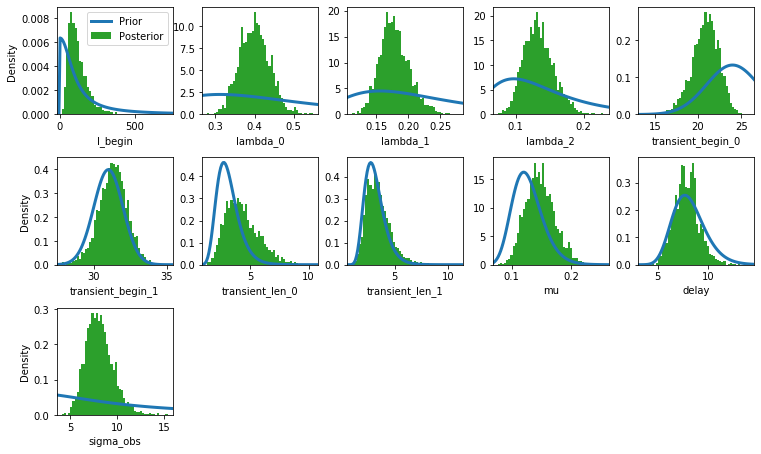

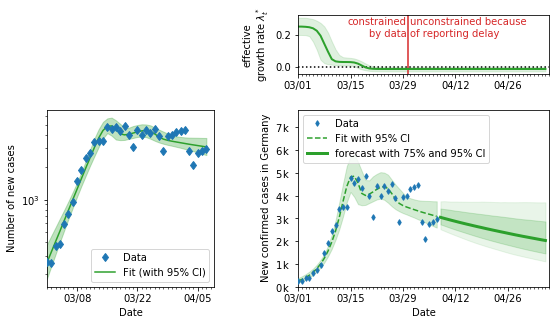

In [65]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig2, axes = cov19.plotting.plot_cases(trace, np.diff(cases_obs), date_begin_sim, diff_data_sim,
                                      colors=('tab:blue', 'tab:green')) 

# Refdatum != Meldedatum - 3 points

In [66]:
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days

cases_obs =  np.array(series_ref_certain[date_data_begin:date_data_end])

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5)]

model = cov19.SIR_with_change_points(np.diff(cases_obs),
                                        change_points,
                                        date_begin_sim,
                                        num_days_sim,
                                        diff_data_sim,
                                     N=83e6)

trace = pm.sample(model=model, init='advi', cores=6)
print(pm.loo(trace, model))

pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
pr_median_transient_len of change point 0 was set to default value 3
pr_median_transient_len of change point 1 was set to default value 3
pr_median_transient_len of change point 2 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3
pr_sigma_transient_len of change point 1 was set to default value 0.3
pr_sigma_transient_len of change point 2 was set to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 355.39:   6%|▌         | 12099/200000 [00:22<05:48, 538.97it/s]
Convergence achieved at 12100
Interrupted at 12,099 [6%]: Average Loss = 466.91
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_obs, delay, mu, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0, lambda_3, lambda_2, lambda_1, lambda_0, I_begin]
Sampling 6 chains, 0 divergences: 100%|██████████| 6000/6000 [05:56<00:00, 16.84draws/s]
The number of effective samples is smaller than 25% for some parameters.


Computed from 3000 by 38 log-likelihood matrix

       Estimate       SE
IC_loo   542.84    10.68
p_loo     12.32        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       33   86.8%
 (0.5, 0.7]   (ok)          5   13.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



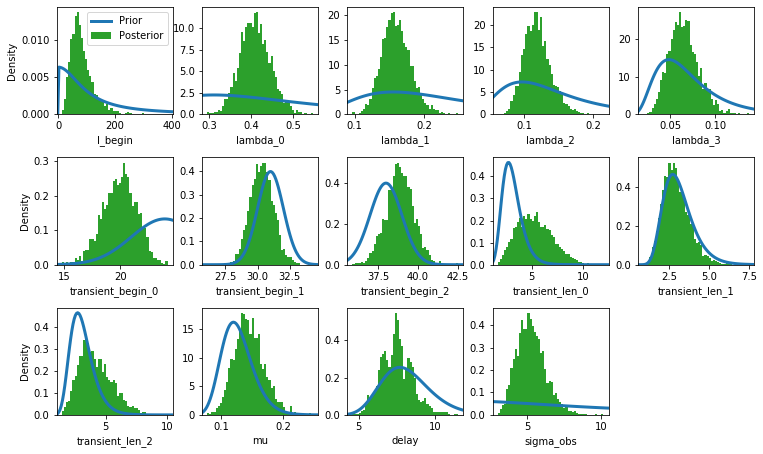

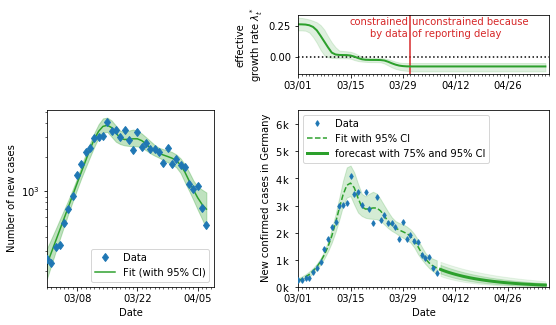

In [67]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig2, axes = cov19.plotting.plot_cases(trace, np.diff(cases_obs), date_begin_sim, diff_data_sim,
                                      colors=('tab:blue', 'tab:green')) 